## Libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pickle

print(f' ------------- \n',
      f'Versions: \n',
      f'------------- \n'
      f' numpy=={np.__version__} \n'
     )

 ------------- 
 Versions: 
 ------------- 
 numpy==1.22.1 



## Reference Values:

In [29]:
h_ref = 1e-2
rho_ref = 5e3
lambda_ref = 2.5e3**2*rho_ref
c_ref = np.sqrt(lambda_ref/rho_ref)

## Material Properties

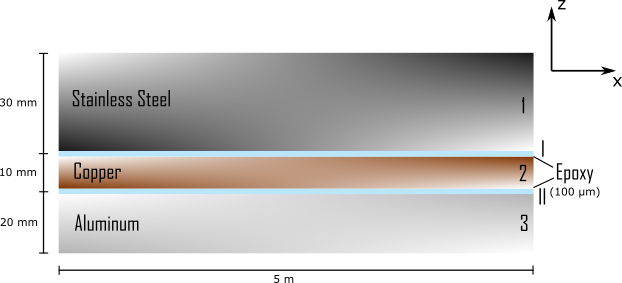

- ### Layer 1 (Aluminum):

In [30]:
rho_1 = 2700/rho_ref
vp_1 = 6320/c_ref
vs_1 = 3130/c_ref
mu_1 = vs_1**2*rho_1
lambda_1 = vp_1**2*rho_1-2*mu_1
h_1 = 2e-2/h_ref

- ### Layer 2 (Copper):

In [31]:
rho_2 = 8930/rho_ref
vp_2 = 4660/c_ref
vs_2 = 2660/c_ref
mu_2 = vs_2**2*rho_2
lambda_2 = vp_2**2*rho_2-2*mu_2
h_2 = 1e-2/h_ref

- ### Layer 3 (Stainless Steel):

In [32]:
rho_3 = 7900/rho_ref
vp_3 = 5790/c_ref
vs_3 = 3100/c_ref
mu_3 = vs_3**2*rho_3
lambda_3 = vp_3**2*rho_3-2*mu_3
h_3 = 3e-2/h_ref

- ### Interfaces:

> ##### Interface II (Layers 1-2)

In [33]:
h_interface_2 = 100e-6/h_ref
vp_interface_2 = 2150/c_ref
vs_interface_2 = 1030/c_ref
rho_interface_2 = 1200/rho_ref

> ##### Interface III (Layers 2-3)

In [34]:
h_interface_3 = 100e-6/h_ref
vp_interface_3 = 2150/c_ref
vs_interface_3 = 1030/c_ref
rho_interface_3 = 1200/rho_ref

> ##### Computing specular stiffness (QSA):

In [35]:
def computeSpecularStiffness(thickness, rho, P_speed, S_speed):
    mu = (S_speed**2)*rho
    lamb = (P_speed**2)*rho-2*mu
    s = 1/mu
    c = 2*mu+lamb
    K_specular = np.linalg.inv(thickness*np.array([[s, 0, 0], [0, s, 0], [0, 0, 1/c]]))
    return K_specular

> ##### Generating Defects:

In [36]:
def computeDefectiveK(K_specular, defect_location, magnitude):
    defect_dict = {'xx': 0, 'yy': 1, 'zz': 2}
    K_defective = K_specular
    loc = defect_dict[defect_location]
    K_defective[loc, loc] = magnitude*K_defective[loc, loc]
    return K_defective

- ### Computing acoustic tensors:

In [37]:
def computePropagationMatrices(kx, kp, kt, h_up, h_down):
    
    kp_z = np.sqrt(kp**2-kx**2, dtype=complex)
    kt_z = np.sqrt(kt**2-kx**2, dtype=complex)
    
    gamma_up = np.zeros((3, 3), dtype=complex)
    np.fill_diagonal(
        gamma_up,
        [np.exp(1j*kp_z*h_up),
         np.exp(1j*kt_z*h_up),
         np.exp(1j*kt_z*h_up)]
    )
    gamma_down = np.zeros((3, 3), dtype=complex)
    np.fill_diagonal(
        gamma_down,
        [np.exp(-1j*kp_z*h_down),
         np.exp(-1j*kt_z*h_down),
         np.exp(-1j*kt_z*h_down)]
    )

    A_up = np.array(
        [[kx/kp, -kt_z/kt, 0],
         [0, 0, 1],
         [kp_z/kp, kx/kt, 0]]
    )
    A_down = np.array(
        [[kx/kp, kt_z/kt, 0],
         [0, 0, 1],
         [-kp_z/kp, kx/kt, 0]]
    )

    M_up = np.dot(np.dot(A_up, gamma_up), np.linalg.inv(A_up))
    M_down = np.dot(np.dot(A_down, gamma_down), np.linalg.inv(A_down))

    return M_up, M_down


########################################################################################


def computeImpedances(omega, kx, kp, kt, lambda_, mu):

    kp_z = np.sqrt(kp**2-kx**2, dtype=complex)
    kt_z = np.sqrt(kt**2-kx**2, dtype=complex)

    A_aux_up = np.array([[kx, kp_z], [kt_z, -kx]], dtype=complex)
    A_aux_down = np.array([[-kx, kp_z], [kt_z, kx]], dtype=complex)

    C1_up = np.array(
        [[-2*mu*kp_z*kx/omega], [(mu/omega)*(kx**2-kt_z**2)]],
        dtype = complex
    )
    C2_up = np.array(
        [[-(lambda_*kp**2+2*mu*kp_z**2)/omega], [2*mu*kt_z*kx/omega]],
        dtype=complex
    )
    C1_down = np.array(
        [[-2*mu*kp_z*kx/omega], [-(mu/omega)*(kx**2-kt_z**2)]],
        dtype=complex
    )
    C2_down = np.array(
        [[(lambda_*kp**2+2*mu*kp_z**2)/omega], [2*mu*kt_z*kx/omega]],
        dtype=complex
    )

    z_11_up_z_13_up = np.dot(np.linalg.inv(A_aux_up), C1_up)
    z_11_up = z_11_up_z_13_up[0]
    z_13_up = z_11_up_z_13_up[1]
    z_12_up = 0
    z_21_up = 0
    z_22_up = -mu*kt_z/omega
    z_23_up = 0
    z_32_up = 0
    z_31_up_z_33_up = np.dot(np.linalg.inv(A_aux_up), C2_up)
    z_31_up = z_31_up_z_33_up[0]
    z_33_up = z_31_up_z_33_up[1]

    z_11_down_z_13_down = np.dot(np.linalg.inv(A_aux_down), C1_down)
    z_11_down = z_11_down_z_13_down[0]
    z_13_down = z_11_down_z_13_down[1]
    z_12_down = 0
    z_21_down = 0
    z_22_down = mu*kt_z/omega
    z_23_down = 0
    z_32_down = 0
    z_31_down_z_33_down = np.dot(np.linalg.inv(A_aux_down), C2_down)
    z_31_down = z_31_down_z_33_down[0]
    z_33_down = z_31_down_z_33_down[1]

    Z_up = np.array(
        [[z_11_up, z_12_up, z_13_up],
         [z_21_up, z_22_up, z_23_up],
         [z_31_up, z_32_up, z_33_up]],
        dtype=complex
    )

    Z_down = np.array(
        [[z_11_down, z_12_down, z_13_down],
         [z_21_down, z_22_down, z_23_down],
         [z_31_down, z_32_down, z_33_down]],
        dtype=complex
    )

    return Z_up, Z_down

- ### Incidence Parameters:

In [55]:
frequency_range = np.arange(0, 300, 0.01)*1e3
kx_range = np.arange(0.0, 3, 0.001)
omega_range = frequency_range*2*np.pi*h_ref/c_ref

## Computing Dispersion Curves (Invariant Embedding)

In [53]:
def computeDispersionCurves(
    vp,
    vs,
    rho,
    thickness,
    K_interfaces,
    kx_range,
    omega_range,
    tol=1
):
    n_layers = len(layers_vp)
    G_det = []
    freq_modes = []
    omega_modes = []
    kx_modes = []
    Gdet_modes = []
    for w in omega_range:
        for kx in kx_range:
            # G = 0 due to the material being in vacuum:
            G = np.zeros((3, 3))
            n_interface = 0
            for layer in range(n_layers):
                h = thickness[layer]
                mu = (vs[layer]**2)*rho[layer]
                lambda_ = (vp[layer]**2)*rho[layer]-2*mu
                kp = w/vp[layer]
                kt = w/vs[layer]
                theta1 = np.arcsin(complex(kx/kp, -0.0))
                theta2 = np.arcsin(complex(kx/kt, -0.0))
                theta3 = theta2
                theta4 = theta1
                theta5 = theta2
                theta6 = theta1
                kz1 = kp*np.cos(theta1)
                kz2 = kt*np.cos(theta2, dtype=complex)
                kz3 = kt*np.cos(theta3, dtype=complex)
                kz4 = kp*np.cos(theta4, dtype=complex)
                kz5 = kt*np.cos(theta5, dtype=complex)
                kz6 = kt*np.cos(theta6, dtype=complex)
                sn4 = np.sin(theta4, dtype=complex)
                sn5 = np.sin(theta5, dtype=complex)
                cn4 = np.cos(theta4, dtype=complex)
                cn5 = np.cos(theta5, dtype=complex)
                M1, M2 = computePropagationMatrices(kx, kp, kt, h, -h)
                Z1, Z2 = computeImpedances(w, kx, kp, kt, lambda_, mu)
                R =  np.dot(np.linalg.inv(G - Z1), (Z2 - G))
                P = np.dot(np.dot(M1, R), M2)
                G = np.dot((np.dot(Z1, P) + Z2), np.linalg.inv(P + np.eye(3)))
                if layer < (n_layers-1):
                    Ginf = np.dot(
                        np.linalg.inv(np.eye(3)-1j*w*np.dot(
                            G,
                            np.linalg.inv(K_interfaces[n_interface])
                        )),
                        G
                    )
                    G = Ginf
                    n_interface += 1
            if G_det:
                G_det.append(np.linalg.det(G))
                if np.abs(G_det[-1]) < tol and (np.sign(np.imag(G_det[-1])) !=  np.sign(np.imag(G_det[-2]))):
                    omega_modes.append(w)
                    freq_modes.append(w/(1e3*2*np.pi*h_ref/c_ref))
                    kx_modes.append(kx)
                    Gdet_modes.append(np.abs(G_det[-1]))
                    
            else:
                G_det.append(np.linalg.det(G))
    return omega_modes, freq_modes, kx_modes, Gdet_modes

# mapping the interfaces:
interfaces_dict = {
        'aluminum-copper': 0,
        'copper-stainless steel': 1
    }

### Saving and plotting the dispersion curves:

In [58]:
def save_curves(sample_name, path, kx_modes, freq_modes, omega_modes):
    with open(f'{path}/kx_{sample_name}', 'wb') as fp:
        pickle.dump(kx_modes, fp)
    with open(f'{path}/freq_{sample_name}', 'wb') as fp:
        pickle.dump(freq_modes, fp)
    with open(f'{path}/omega_{sample_name}', 'wb') as fp:
        pickle.dump(omega_modes, fp)

def load_curves(sample_name, path):
    with open(f'{path}/kx_{sample_name}', "rb") as fp:
        kx_modes = pickle.load(fp)
    with open(f'{path}/freq_{sample_name}', "rb") as fp:
        freq_modes = pickle.load(fp)
    with open(f'{path}/omega_{sample_name}', "rb") as fp:
        omega_modes = pickle.load(fp)

    return kx_modes, freq_modes, omega_modes

- #### Flawless interfaces dispersion curves:

In [20]:
layers_vp = [vp_1, vp_2, vp_3]
layers_vs = [vs_1, vs_2, vs_3]
layers_rho = [rho_1, rho_2, rho_3]
layers_thickness = [h_1, h_2, h_3]
K_specular_2 = computeSpecularStiffness(
    h_interface_2,
    rho_interface_2,
    vp_interface_2,
    vs_interface_2
)
K_specular_3 = computeSpecularStiffness(
    h_interface_3,
    rho_interface_3,
    vp_interface_3,
    vs_interface_3
)
K_interfaces = [K_specular_2, K_specular_3]

omega_modes, freq_modes, kx_modes, Gdet_modes = computeDispersionCurves(
    layers_vp,
    layers_vs,
    layers_rho,
    layers_thickness,
    K_interfaces,
    kx_range,
    omega_range,
    tol=10
)

path = './results/dispersion_curves'
sample_name = 'flawless_tol10'

save_curves(sample_name, path, kx_modes, freq_modes, omega_modes)

C:\Users\berna\AppData\Local\Temp/ipykernel_18744/1158131242.py:90: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  Z_up = np.array(
C:\Users\berna\AppData\Local\Temp/ipykernel_18744/1158131242.py:97: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  Z_down = np.array(


- #### Flawed interface dispersion curves:

In [56]:
interface_of_interest = 'copper-stainless steel'
direction_of_interest = 'xx'

In [57]:
layers_vp = [vp_1, vp_2, vp_3]
layers_vs = [vs_1, vs_2, vs_3]
layers_rho = [rho_1, rho_2, rho_3]
layers_thickness = [h_1, h_2, h_3]
K_specular_2 = computeSpecularStiffness(
    h_interface_2,
    rho_interface_2,
    vp_interface_2,
    vs_interface_2
)
K_specular_3 = computeSpecularStiffness(
    h_interface_3,
    rho_interface_3,
    vp_interface_3,
    vs_interface_3
)
K_interfaces = [K_specular_2, K_specular_3]
n_interface = interfaces_dict[interface_of_interest]
K_interfaces[n_interface] = computeDefectiveK(
    K_interfaces[n_interface],
    defect_location=direction_of_interest,
    magnitude=0.5
)

omega_modes, freq_modes, kx_modes, Gdet_modes = computeDispersionCurves(
    layers_vp,
    layers_vs,
    layers_rho,
    layers_thickness,
    K_interfaces,
    kx_range,
    omega_range,
    tol=10
)

path = './results/dispersion_curves'
sample_name = 'xx_interface3_tol10'

save_curves(sample_name, path, kx_modes, freq_modes, omega_modes)

C:\Users\berna\AppData\Local\Temp\ipykernel_10368\1158131242.py:90: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  Z_up = np.array(
C:\Users\berna\AppData\Local\Temp\ipykernel_10368\1158131242.py:97: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  Z_down = np.array(


In [61]:
path = './results/dispersion_curves'
kx_modes, freq_modes, _ = load_curves(sample_name='flawless_tol10', path=path)
kx_modes_defective, freq_modes_defective, _ = load_curves(sample_name='xx_interface3_tol10', path=path)

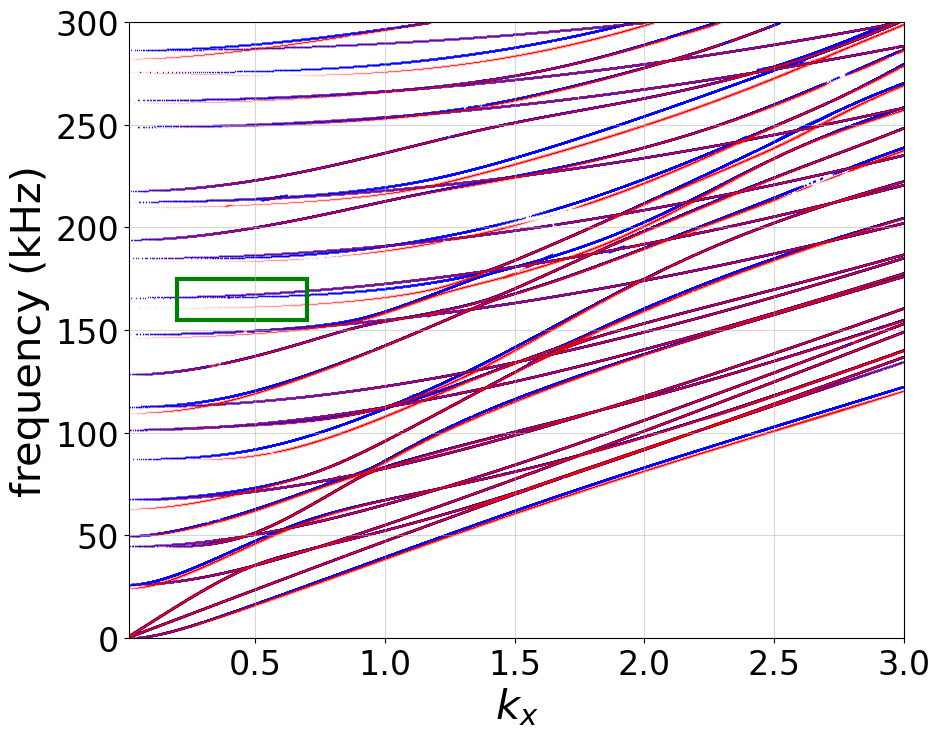

In [80]:
fig, ax = plt.subplots(figsize=(10, 8))

# Display the image
ax.scatter(kx_modes, freq_modes, s=1, color='b', marker='d', linewidths=0.05)
ax.scatter(kx_modes_defective, freq_modes_defective, s=1, color='r', marker='x', linewidths=0.05)
ax.grid(alpha=0.5)
ax.set_xlabel('$k_x$', size=30)
ax.set_ylabel('frequency (kHz)', size=30)
ax.set_xlim([0.015, 3])
ax.set_ylim([0, 300])
ax.tick_params(labelsize=24)
plt.savefig("dispersion_xx.pdf", bbox_inches="tight")
plt.show()

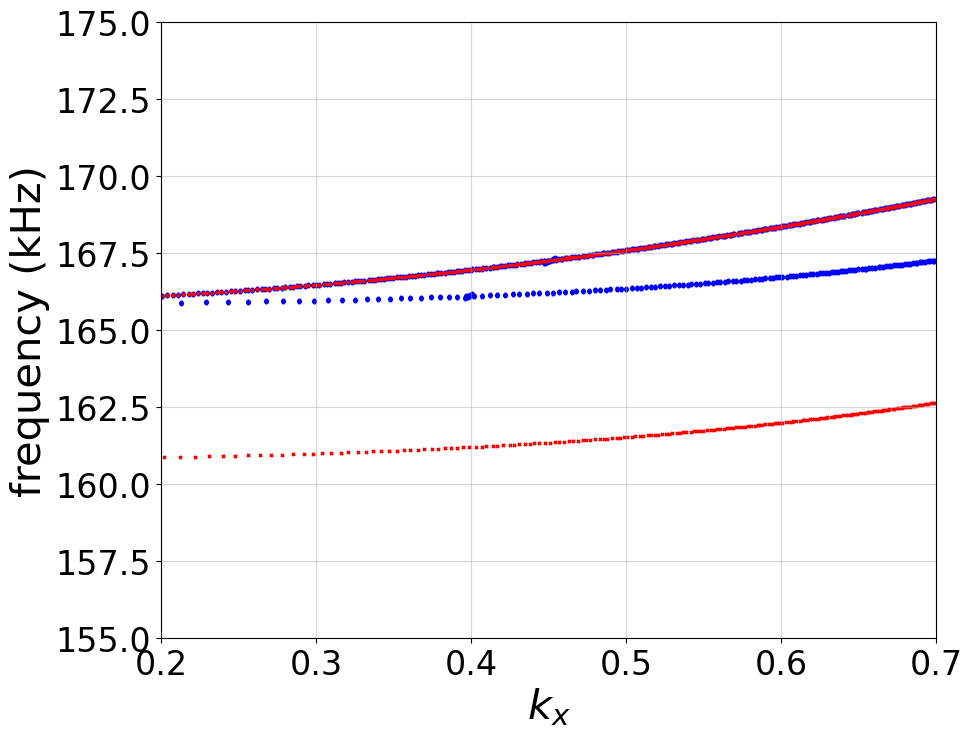

In [81]:
# Zoomed image
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(kx_modes_T, freq_modes_T, s=1, color='b', marker='d', linewidths=3)
ax.scatter(kx_modes_defective_T, freq_modes_defective_T, s=1, color='r', marker='x', linewidths=3)
ax.grid(alpha=0.5)
ax.set_xlabel('$k_x$', size=30)
ax.set_ylabel('frequency (kHz)', size=30)
#ax.set_title('Copper-Aluminum interface - z direction', size=36)
ax.set_xlim([0.2, 0.7])
ax.set_ylim([155, 175])
ax.tick_params(labelsize=24)
plt.savefig("dispersion_III_xx_zoom.pdf", bbox_inches="tight")
plt.show()

- #### Refining the search around the mode of interest:

In [170]:
frequency_range = np.arange(165, 166, 0.001)*1e3
kx_range = np.arange(0.02, 0.05, 0.0001)
omega_range = frequency_range*2*np.pi*h_ref/c_ref

In [171]:
layers_vp = [vp_1, vp_2, vp_3]
layers_vs = [vs_1, vs_2, vs_3]
layers_rho = [rho_1, rho_2, rho_3]
layers_thickness = [h_1, h_2, h_3]
K_specular_2 = computeSpecularStiffness(
    h_interface_2,
    rho_interface_2,
    vp_interface_2,
    vs_interface_2
)
K_specular_3 = computeSpecularStiffness(
    h_interface_3,
    rho_interface_3,
    vp_interface_3,
    vs_interface_3
)
K_interfaces = [K_specular_2, K_specular_3]

omega_modes, freq_modes, kx_modes, Gdet_modes = computeDispersionCurves(
    layers_vp,
    layers_vs,
    layers_rho,
    layers_thickness,
    K_interfaces,
    kx_range,
    omega_range,
    tol=1e-2
)

C:\Users\berna\AppData\Local\Temp\ipykernel_10368\1158131242.py:90: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  Z_up = np.array(
C:\Users\berna\AppData\Local\Temp\ipykernel_10368\1158131242.py:97: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  Z_down = np.array(


- #### Choosing and saving the mode parameters with the lowest det(G):

In [172]:
min_index = Gdet_modes.index(min(Gdet_modes))
print('Chosen Mode: \n',
      f' frequency = {freq_modes[min_index]} kHz \n',
      f' kx = {kx_modes[min_index]} \n',
      f'det(G)={min(Gdet_modes)}'
     )

Chosen Mode: 
  frequency = 165.83800000000394 kHz 
  kx = 0.03199999999999993 
 det(G)=1.5523802422647286e-08


In [175]:
def save_mode_parameters():
    with open(f'./results/modes_parameters/kx_{interface_of_interest}_{direction_of_interest}', 'wb') as fp:
        pickle.dump(kx_modes[min_index], fp)
    with open(f'./results/modes_parameters/freq_{interface_of_interest}_{direction_of_interest}', 'wb') as fp:
        pickle.dump(freq_modes[min_index], fp)

In [176]:
save_mode_parameters()